In [2]:
import pandas as pd
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt


import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
import numpy as np
import matplotlib.pyplot as plt

get_ipython().run_line_magic("matplotlib", "inline")
font = {"weight": "normal", "size": 14, "family": "DejaVu Sans"}
plt.rc("text", usetex=True)
plt.rc("font", **font)

def rec_dd():
    return defaultdict(rec_dd)


In [3]:
benchmark_path_synth = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_synthetic_dataset"
)
benchmark_path_partis = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset"
)
hilary_full = "hilary-full-1-2-0"
hilary_cdr3 = "hilary-CDR3-1-2-0"
hilary_cdr3_partis = "hilary-cdr3-1-2-0"


In [4]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [10]:
metric_dict_cdr=rec_dd()
for set in [1,2,3,4,5]:
    prec_list=[]
    sens_list=[]
    var_list=[]
    for l in range(15,48,3):
        dataframe=pd.DataFrame()
        for model in [f"crude_{str(each/100)}" for each in [12,18,24]]+[hilary_full, hilary_cdr3]:
            print(model)
            if model.startswith("hilary"):

                if model.startswith("hilary-CDR3"):
                    df = pd.read_csv(benchmark_path_synth
                        / Path(
                            f"{model}/set{set}/inferred_cdr3_based_families{set}_1e4_ppost326651_mut326713_cdr3l{l}.csv"
                        ),
                        index_col="sequence_id",
                    )
                    dataframe[model] = df["cdr3_based_family"]

                else :
                    df = pd.read_csv(
                        benchmark_path_synth
                        / Path(
                            f"{model}/set{set}/inferred_full_method_families{set}_1e4_ppost326651_mut326713_cdr3l{l}.csv"
                        ),
                        index_col="sequence_id",
                    )
                    dataframe[model]=df["family"]

            else :
                df = pd.read_csv(
                benchmark_path_synth
                / Path(
                    f"{model}/set{set}/inferred_crude_method_families{set}_1e4_ppost326651_mut326713_cdr3l{l}.csv"
                ),
                index_col="sequence_id",
            )
                dataframe[model] = df["crude_method_family"]
            if "simulations" not in df.columns:
                dataframe["simulations"]=df["FAMILY"]
            sensitivity,precision=pairwise_evaluation(dataframe,model)
            varinfo = variation_of_info(dataframe,model)
            metric_dict_cdr[model]["precision"][l][set]=precision
            metric_dict_cdr[model]["sensitivity"][l][set]=sensitivity
            metric_dict_cdr[model]["variation_of_info"][l][set]=varinfo

metric_dict_shm = rec_dd()
for seed in [0, 1, 2]:
    prec_list = []
    sens_list = []
    var_list = []
    for freq in ["0.01", "0.05", "0.10", "0.20", "0.30"]:
        dataframe = pd.DataFrame()
        for model in (
            ["simulations"]
            + [f"crude_{str(each/100)}" for each in [12, 18, 24]]
            + [hilary_full, hilary_cdr3_partis]
        ):
            if model == "simulations":
                df = pd.read_csv(
                    [
                        each
                        for each in (
                            benchmark_path_partis
                            / Path(
                                f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/"
                            )
                        ).glob(f"*igh.tsv")
                    ][0],
                    sep="\t",
                    index_col="sequence_id",
                )
                dataframe[model] = df["clone_id"]

            elif model.startswith("hilary"):

                if model.startswith("hilary-cdr3"):
                    df = pd.read_csv(
                        benchmark_path_partis
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/inferred_cdr3_based_igh.tsv"
                        ),
                        index_col="sequence_id",
                        sep="\t",
                    )
                    dataframe[model] = df["cdr3_based_family"]

                else:
                    df = pd.read_csv(
                        benchmark_path_partis
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/inferred_full_method_igh.tsv"
                        ),
                        index_col="sequence_id",
                        sep="\t",
                    )
                    dataframe[model] = df["family"]

            else:
                df = pd.read_csv(
                    benchmark_path_partis
                    / Path(
                        f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/inferred_crude_method_igh.tsv"
                    ),
                    sep="\t",
                    index_col="sequence_id",
                )
                dataframe[model] = df["crude_method_family"]

            sensitivity, precision = pairwise_evaluation(dataframe, model)
            varinfo = variation_of_info(dataframe, model)
            metric_dict_shm[model]["precision"][freq][seed] = precision
            metric_dict_shm[model]["sensitivity"][freq][seed] = sensitivity
            metric_dict_shm[model]["variation_of_info"][freq][seed] = varinfo


crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
hilary-full-1-2-0
hilary-CDR3-1-2-0
crude_0.12
crude_0.18
crude_0.24
h

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

colormap2 = cm.get_cmap("gist_earth", 12)


crude_0.12
precision
sensitivity
variation_of_info
crude_0.18
precision
sensitivity
variation_of_info
crude_0.24
precision
sensitivity
variation_of_info
hilary-full-1-2-0
precision
sensitivity
variation_of_info
hilary-CDR3-1-2-0
precision
sensitivity
variation_of_info
hilary-cdr3-1-2-0
crude_0.12
precision
sensitivity
variation_of_info
crude_0.18
precision
sensitivity
variation_of_info
crude_0.24
precision
sensitivity
variation_of_info
hilary-full-1-2-0
precision
sensitivity
variation_of_info
hilary-CDR3-1-2-0
hilary-cdr3-1-2-0
precision
sensitivity
variation_of_info


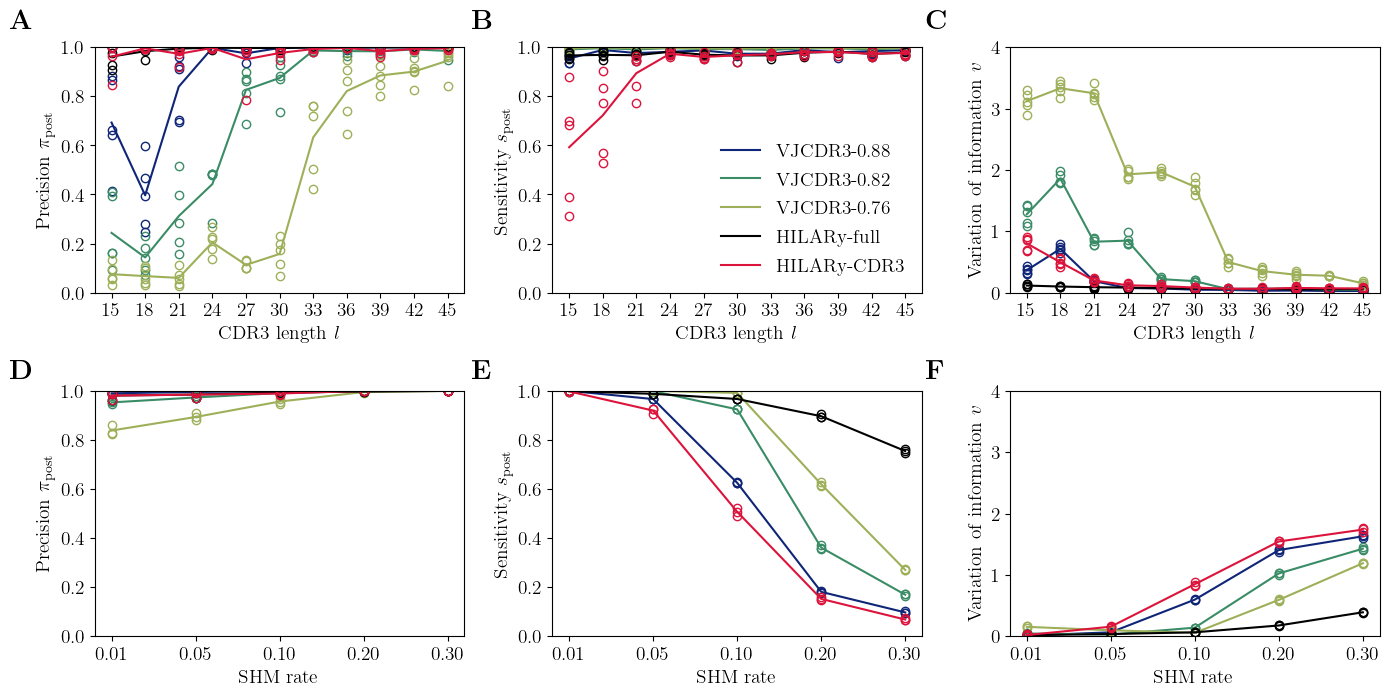

In [31]:
ls = np.arange(15, 45 + 3, 3)
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(231)
ax1.set_ylabel(r"Precision $\pi_{\rm post}$")
ax1.set_xlabel(r"CDR3 length $l$")
ax2 = fig.add_subplot(232)
ax2.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax2.set_xlabel(r"CDR3 length $l$")
ax3 = fig.add_subplot(233)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel(r"CDR3 length $l$")

axes = [ax1, ax2, ax3]

colors = {
    f"crude_{str(each/100)}": colormap2((each-9)/24)
    for i,each in enumerate([12,18,24])
}
colors[hilary_full]="k"
colors[hilary_cdr3]="crimson"
colors[hilary_cdr3_partis] = "crimson"


labels = {
    f"crude_{str(each/100)}": f"VJCDR3-{str(round(1 - each / 100, 2))}"
    for each in [12,18,24]
}

for model in colors:
    print(model)
    if model.startswith("crude"):
        label = labels[model]
    if model==hilary_full:
        label="HILARy-full"
    if model == hilary_cdr3:
        label = "HILARy-CDR3"
    for i, metric in enumerate(metric_dict_cdr[model]):
        print(metric)
        for l in metric_dict_cdr[model][metric]:
            y = list(metric_dict_cdr[model][metric][l].values())
            x = [l] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for length in metric_dict_cdr[model][metric]:
            lengths.append(length)
            averages.append(np.mean(list(metric_dict_cdr[model][metric][length].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )


ax1.set_xticks(ls)
ax1.set_xticklabels(ls)
ax2.set_xticks(ls)
ax2.set_xticklabels(ls)
ax3.set_xticks(ls)
ax3.set_xticklabels(ls)

ax2.legend(frameon=False)

ls = [0.01, 0.05, 0.10, 0.20, 0.30]
ax4 = fig.add_subplot(234)
ax4.set_ylabel(r"Precision $\pi_{\rm post}$")
ax4.set_xlabel(r"SHM rate")
ax5 = fig.add_subplot(235)
ax5.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax5.set_xlabel(r"SHM rate")
ax6 = fig.add_subplot(236)
ax6.set_ylabel(r"Variation of information $v$")
ax6.set_xlabel(r"SHM rate")

labels = {
    f"crude_{str(each/100)}": f"VJCDR3-{str(round(1 - each / 100, 2))}"
    for each in [12, 18, 24]
}
axes = [ax4, ax5, ax6]

for model in colors:
    if model.startswith("crude"):
        label = f"{labels[model]}"
    if model == hilary_full:
        label = "HILARy-full"
    if model == hilary_cdr3_partis:
        label = "HILARy-CDR3"
    print(model)
    for i, metric in enumerate(metric_dict_shm[model]):
        print(metric)
        for freq in metric_dict_shm[model][metric]:
            y = list(metric_dict_shm[model][metric][freq].values())
            x = [freq] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for freq in metric_dict_shm[model][metric]:
            lengths.append(freq)
            averages.append(
                np.mean(list(metric_dict_shm[model][metric][freq].values()))
            )
        axes[i].plot(lengths, averages, color=colors[model], label=label)

ax1.set_ylim(bottom=0,top=1)
ax2.set_ylim(bottom=0, top=1)
ax3.set_ylim(bottom=0, top=4)
ax4.set_ylim(bottom=0, top=1)
ax5.set_ylim(bottom=0, top=1)
ax6.set_ylim(bottom=0, top=4)

ax1.set_ylim(bottom=0, top=1)
ax2.set_ylim(bottom=0, top=1)
ax3.set_ylim(bottom=0)

plt.tight_layout(pad=1.4)
plt.text(-12.1, 9.9, r"\bf{A}", rotation=0, wrap=True, fontsize=20)
plt.text(-6.6, 9.9, r"\bf{B}", rotation=0, wrap=True, fontsize=20)
plt.text(-1.2, 9.9, r"\bf{C}", rotation=0, wrap=True, fontsize=20)
plt.text(-12.1, 4.2, r"\bf{D}", rotation=0, wrap=True, fontsize=20)
plt.text(-6.6, 4.2, r"\bf{E}", rotation=0, wrap=True, fontsize=20)
plt.text(-1.2, 4.2, r"\bf{F}", rotation=0, wrap=True, fontsize=20)
fig.subplots_adjust(hspace=0.4)


# fig.savefig('new_figures/figure4.pdf',bbox_inches='tight',dpi=1000)
plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_01_26/figures/si_figure10.pdf",
    bbox_inches="tight",
)
plt.show()
